Total Return 38.740000000012515
Total Trade Num 779
Max Drawdown: 1322.68%
Profit Factor: 16.09225273358753
Long Trade Num: 31
Long Win Rate: 51.61%
Short Trade Num: 62
Short Win Rate: 61.29%


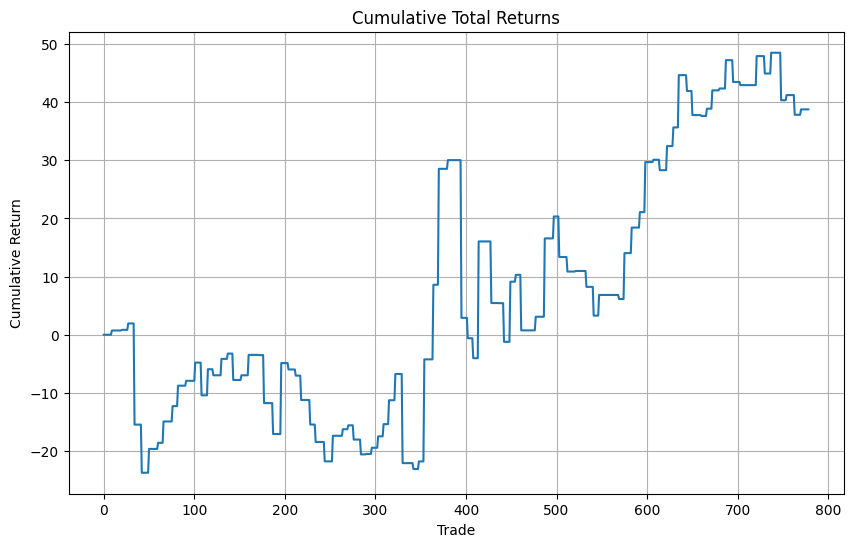

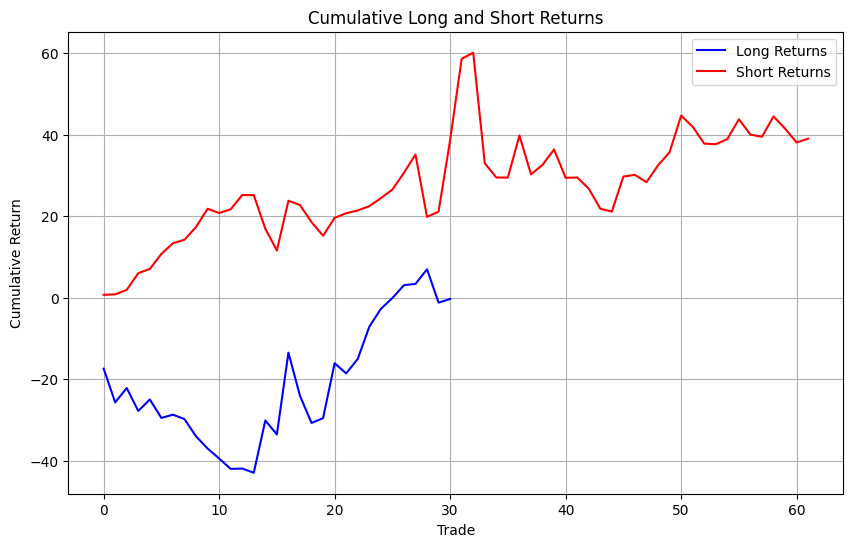

In [7]:
import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def load_data(file_names):
    dfs = []
    for file_name in file_names:
        df = pd.read_csv(file_name)
        dfs.append(df)
    return dfs

def predict(data_row):
    if "5m_target" in data_row.index:
        data_row = data_row.drop("5m_target")
    
    # Reshape the data_row into the correct format
    data_row = data_row.values.reshape(1, -1)
    prediction_proba = model.predict(data_row)
    predicted_class = [1 if prob > 0.5 else 0 for prob in prediction_proba]

    return predicted_class[0]

# feature engineering
def feature_engineering(df, prefix):
    open = df[f'{prefix}_open'].values
    high = df[f'{prefix}_high'].values
    low = df[f'{prefix}_low'].values
    close = df[f'{prefix}_close'].values
    volume = df[f'{prefix}_volume'].values
    hilo = (high + low) / 2

    df[f'{prefix}_RSI_ST'] = talib.RSI(close)/close
    df[f'{prefix}_RSI_LOG'] = log_transform_feature(talib.RSI(close))
    df[f'{prefix}_MACD'], _, _ = talib.MACD(close)
    df[f'{prefix}_MACD_ST'], _, _ = talib.MACD(close)/close
    df[f'{prefix}_ATR'] = talib.ATR(high, low, close)
    df[f'{prefix}_ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df[f'{prefix}_ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    
    df[f'{prefix}_SMA10'] = talib.SMA(close, timeperiod=10)
    df[f'{prefix}_SMA50'] = talib.SMA(close, timeperiod=50)
    df[f'{prefix}_SMA100'] = talib.SMA(close, timeperiod=100)
    
    df[f'{prefix}_BB_UPPER'], df[f'{prefix}_BB_MIDDLE'], df[f'{prefix}_BB_LOWER'] = talib.BBANDS(close)
    df[f'{prefix}_BBANDS_upperband'] = (df[f'{prefix}_BB_UPPER'] - hilo) / close
    df[f'{prefix}_BBANDS_middleband'] = (df[f'{prefix}_BB_MIDDLE'] - hilo) / close
    df[f'{prefix}_BBANDS_lowerband'] = (df[f'{prefix}_BB_LOWER'] - hilo) / close
    df[f'{prefix}_STOCH_K'], df[f'{prefix}_STOCH_D'] = talib.STOCH(high, low, close)/close
    df[f'{prefix}_MON'] = talib.MOM(close, timeperiod=5)
    df[f'{prefix}_OBV'] = talib.OBV(close, volume)

    # Calculate high_close_comparison
    df[f'{prefix}_High_Close_Comparison'] = calculate_high_close_comparison(df, prefix)
    df[f'{prefix}_double_top'], df[f'{prefix}_double_bottom'] = detect_double_top_bottom(df, prefix)

    df = df.dropna()
    df = df.reset_index(drop=True)

    return df

def log_transform_feature(X):
    X[X <= 0] = np.finfo(float).eps
    return np.log(X)

def calculate_high_close_comparison(df, prefix):
    high = df[f'{prefix}_high'].values
    close = df[f'{prefix}_close'].values
    higher_high = np.zeros(len(high), dtype=int)
    higher_close = np.zeros(len(close), dtype=int)
    higher_high[1:] = high[1:] > high[:-1]
    higher_close[1:] = close[1:] > close[:-1]
    high_close_comparison = higher_high & higher_close
    return high_close_comparison

def detect_double_top_bottom(df, prefix, window=5, tolerance=0.03):
    double_top = np.zeros(len(df), dtype=int)
    double_bottom = np.zeros(len(df), dtype=int)

    close = df[f'{prefix}_close'].values
    close_ext = np.pad(close, (window, window), mode='edge')

    for i in range(window, len(df) - window):
        considered_range = close_ext[i:i + window * 2 + 1]
        max_index = np.argmax(considered_range)
        min_index = np.argmin(considered_range)

        if max_index == window:
            max_left = np.max(considered_range[:window])
            max_right = np.max(considered_range[window + 1:])
            max_avg = (max_left + max_right) / 2

            if np.abs(considered_range[window] - max_avg) / considered_range[window] <= tolerance:
                double_top[i] = 1

        if min_index == window:
            min_left = np.min(considered_range[:window])
            min_right = np.min(considered_range[window + 1:])
            min_avg = (min_left + min_right) / 2

            if np.abs(considered_range[window] - min_avg) / considered_range[window] <= tolerance:
                double_bottom[i] = 1

    return double_top, double_bottom

def create_label(df, prefix, lookbehind=1):
    df[f'{prefix}_target'] = (df[f'{prefix}_close'] > df[f'{prefix}_close'].shift(lookbehind)).astype(int)
    df = df.dropna()
    return df

def support_resistance(df, prefix, window=200):
    high = df[f'{prefix}_high']
    low = df[f'{prefix}_low']
    df[f'{prefix}_support'] = low.rolling(window=window, min_periods=1).min()
    df[f'{prefix}_resistance'] = high.rolling(window=window, min_periods=1).max()
    return df

def price_relation(df, short_prefix, long_prefix):
    short_close = df[f'{short_prefix}_close']
    long_support = df[f'{long_prefix}_support']
    long_resistance = df[f'{long_prefix}_resistance']
    df[f'{short_prefix}_close_to_{long_prefix}_support'] = (short_close - long_support) / long_support
    df[f'{short_prefix}_close_to_{long_prefix}_resistance'] = (short_close - long_resistance) / long_resistance
    return df

def summarize_trade_results(trade_results):
    num_trades = len(trade_results['profits'])
    num_wins = sum(1 for x in trade_results['profits'] if x > 0)
    num_losses = num_trades - num_wins

    total_return = sum(trade_results['profits'])

    average_win = sum(x for x in trade_results['profits'] if x > 0) / num_wins if num_wins > 0 else 0
    average_loss = sum(x for x in trade_results['profits'] if x < 0) / num_losses if num_losses > 0 else 0

    profit_factor = -average_win / average_loss if average_loss != 0 else 0

    long_win_rate = sum(1 for x in trade_results['long_profits'] if x > 0) / len(trade_results['long_profits']) if trade_results['long_profits'] else 0
    short_win_rate = sum(1 for x in trade_results['short_profits'] if x > 0) / len(trade_results['short_profits']) if trade_results['short_profits'] else 0

    # Create cumulative return series
    cumulative_returns = np.cumsum(trade_results['profits'])
    cumulative_long_returns = np.cumsum(trade_results['long_profits'])
    cumulative_short_returns = np.cumsum(trade_results['short_profits'])

    # Calculate maximum drawdown using numpy
    cumulative_max = np.maximum.accumulate(cumulative_returns)
    non_zero_max = cumulative_max > 0
    drawdowns = np.full_like(cumulative_returns, fill_value=0)
    drawdowns[non_zero_max] = 1 - cumulative_returns[non_zero_max] / cumulative_max[non_zero_max]
    max_drawdown = np.max(drawdowns)

    # Print the statistics
    print(f"Total Return: {total_return}")
    print(f"Total Trade Num: {len(trade_results['profits'])}")
    print(f"Max Drawdown: {max_drawdown * 100:.2f}%")
    print(f"Profit Factor: {profit_factor}")
    print(f"Long Trade Num: {len(trade_results['long_profits'])}")
    print(f"Long Win Rate: {long_win_rate * 100:.2f}%")
    print(f"Short Trade Num: {len(trade_results['short_profits'])}")
    print(f"Short Win Rate: {short_win_rate * 100:.2f}%")

    # Plot the results
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_returns, label='Total Returns')
    plt.title("Cumulative Total Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_long_returns, label='Long Returns', color='blue')
    plt.plot(cumulative_short_returns, label='Short Returns', color='red')
    plt.title("Cumulative Long and Short Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

def calc_trade_fee(price):
    fee_rate = 0.001
    return price * fee_rate

if __name__ == "__main__":
    file_names = [
        "data/testdata/BTCUSDT_1m_20230101_20230525.csv", 
        "data/testdata/BTCUSDT_5m_20230101_20230525.csv", 
        "data/testdata/BTCUSDT_15m_20230101_20230525.csv", 
        "data/testdata/BTCUSDT_30m_20230101_20230525.csv", 
        "data/testdata/BTCUSDT_1h_20230101_20230525.csv", 
        "data/testdata/BTCUSDT_4h_20230101_20230525.csv",
        # "data/testdata/BTCUSDT_1d_20230101_20230525.csv",
        ]
    dfs = load_data(file_names)

    processed_dfs = []
    for df in dfs:
        prefix = df.columns[0].split('_')[0]
        processed_df = feature_engineering(df, prefix)
        processed_df = create_label(processed_df, prefix)
        # display(processed_df)
        processed_dfs.append(processed_df)

    combined_df = pd.concat(processed_dfs, axis=1).dropna()

    # add feature support and resistance
    combined_df = support_resistance(combined_df, "1m")
    combined_df = support_resistance(combined_df, "5m")
    combined_df = support_resistance(combined_df, "15m")
    combined_df = support_resistance(combined_df, "30m")
    combined_df = support_resistance(combined_df, "1h")
    combined_df = support_resistance(combined_df, "4h")
    # combined_df = support_resistance(combined_df, "1d")
    combined_df = price_relation(combined_df, '1m', '5m')
    combined_df = price_relation(combined_df, '5m', '15m')
    combined_df = price_relation(combined_df, '5m', '30m')
    combined_df = price_relation(combined_df, '5m', '1h')
    combined_df = price_relation(combined_df, '5m', '4h')
    # combined_df = price_relation(combined_df, '5m', '1d')

    model_path = "model/5m_model.pkl"
    with open(model_path, "rb") as f:
        model = pickle.load(f)

    # Initialize trade_results
    trade_results = {
        'profits': [],
        'long_profits': [],
        'short_profits': [],
    }

    # Initialize portfolio state
    portfolio = {
        'position': None,  # "long" or "short"
        'entry_price': None,
        'entry_point': 0
    }

    # Loop through the data
    for i in range(0, len(combined_df)):
        profit = 0

        # Get the current row of data
        data_row = combined_df.iloc[i]

        # Retrieve the Bollinger Bands from the row
        upper = data_row['1m_BB_UPPER']
        lower = data_row['1m_BB_LOWER']

        # Make a prediction with the model
        y_pred = predict(data_row)

        if portfolio['position'] is not None:
            if portfolio['entry_point'] + 5 == i:
                if portfolio['position'] == 'long':
                    profit = data_row['1m_close'] - portfolio['entry_price']
                    trade_results['profits'].append(profit)
                    trade_results['long_profits'].append(profit)
                    portfolio = {
                        'position': None,
                        'entry_price': None,
                        'entry_point': 0
                    }
                elif portfolio['position'] == 'short':
                    profit = portfolio['entry_price'] - data_row['1m_close']
                    trade_results['profits'].append(profit)
                    trade_results['short_profits'].append(profit)
                    portfolio = {
                        'position': None,
                        'entry_price': None,
                        'entry_point': 0
                    }
            else:
                trade_results['profits'].append(profit)
        
        elif data_row['1m_high'] >= upper:
            if y_pred == 1:
                trade_results['profits'].append(profit)
                portfolio = {
                    'position': 'long',
                    'entry_price': data_row['1m_close'],
                    'entry_point': i
                }
            elif y_pred == 0:
                trade_results['profits'].append(profit)
                portfolio = {
                    'position': 'short',
                    'entry_price': data_row['1m_close'],
                    'entry_point': i
                }

        # If the Bollinger Bands reach 2 sigma
        elif data_row['1m_low'] <= lower:
            if y_pred == 1:
                trade_results['profits'].append(profit)
                portfolio = {
                    'position': 'long',
                    'entry_price': data_row['1m_close'],
                    'entry_point': i
                }
            elif y_pred == 0:
                trade_results['profits'].append(profit)
                portfolio = {
                    'position': 'short',
                    'entry_price': data_row['1m_close'],
                    'entry_point': i
                }

        else:
            trade_results['profits'].append(profit)

    summarize_trade_results(trade_results)